In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error

# Linear and Logistic Regression

### Lecture 2

In [65]:
data = pd.read_csv('data/StockX-Data-Contest-2019-3.csv')
data

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island
...,...,...,...,...,...,...,...,...
99951,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$565,$220,12/26/18,8.0,Oregon
99952,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$598,$220,12/26/18,8.5,California
99953,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$605,$220,12/26/18,5.5,New York
99954,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,$650,$220,12/26/18,11.0,California


In [66]:
#Transform features name with `to lower` and replace the space between two or three words with underscore
data = data.rename(columns=lambda x: x.lower().replace(' ', '_'))

In [67]:
#Check for empty values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_date    99956 non-null  object 
 1   brand         99956 non-null  object 
 2   sneaker_name  99956 non-null  object 
 3   sale_price    99956 non-null  object 
 4   retail_price  99956 non-null  object 
 5   release_date  99956 non-null  object 
 6   shoe_size     99956 non-null  float64
 7   buyer_region  99956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [68]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
shoe_size,99956.0,9.344181,2.329588,3.5,8.0,9.5,11.0,17.0


In [69]:
any(~data.retail_price.str.startswith('$'))

False

In [70]:
#Remove dollar sign from the feature
def remove_dollar_sign(dataset, target_feature):
    for col in target_feature:
        dataset[col] = dataset[col].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
    
    return dataset

data = remove_dollar_sign(data, ['sale_price', 'retail_price'])

In [71]:
data

,order_date,brand,sneaker_name,sale_price,retail_price,release_date,shoe_size,buyer_region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220.0,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220.0,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220.0,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220.0,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220.0,2/11/17,11.0,Rhode Island
...,...,...,...,...,...,...,...,...
99951,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220.0,12/26/18,8.0,Oregon
99952,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220.0,12/26/18,8.5,California
99953,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220.0,12/26/18,5.5,New York
99954,2/13/19,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220.0,12/26/18,11.0,California


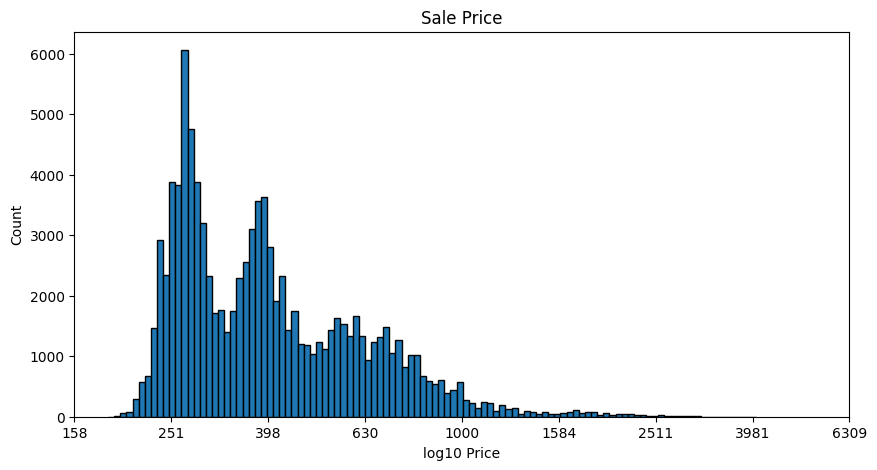

In [72]:
#Show histogram of sale_price and retail_price
plt.figure(figsize=(10, 5))
plt.hist(np.log10(data.sale_price), bins='auto', edgecolor='black')
plt.title('Sale Price')
ticks, labels = plt.xticks()
plt.xticks(ticks, [int(10 ** t) for t in ticks])
plt.xlabel('log10 Price')
plt.ylabel('Count')
plt.show()

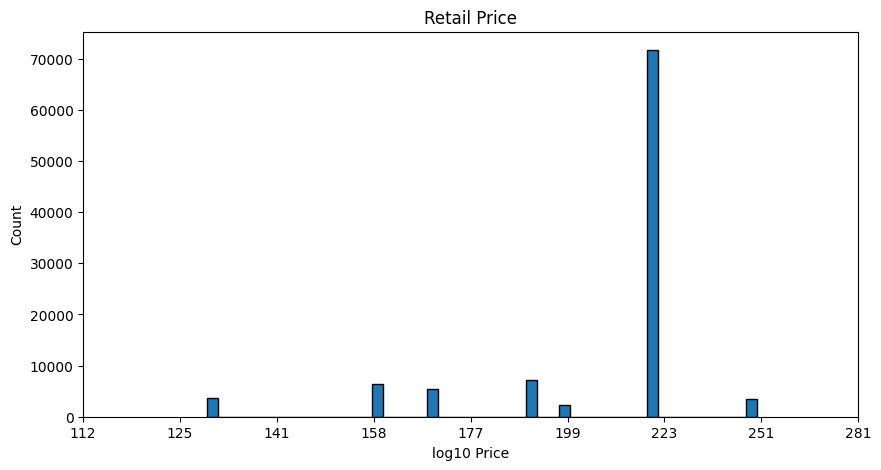

In [73]:
plt.figure(figsize=(10, 5))
plt.hist(np.log10(data.retail_price), bins=50, edgecolor='black')
plt.title('Retail Price')
ticks, label = plt.xticks()
plt.xticks(ticks, [int(10 ** t) for t in ticks])
plt.xlabel('log10 Price')
plt.ylabel('Count')
plt.show()

In [74]:
data.brand.value_counts()

brand
 Yeezy       72162
Off-White    27794
Name: count, dtype: int64

In [75]:
pd.get_dummies(data.buyer_region, drop_first=True).astype(int)

,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
data = pd.concat([
    data, 
    pd.get_dummies(data.buyer_region, drop_first=True).astype(int)], 
    axis='columns')
data = data.drop(columns=['buyer_region'])

In [77]:

data = pd.concat([
    data, 
    pd.get_dummies(data.brand, drop_first=True).astype(int)], 
    axis='columns')
data = data.drop(columns=['brand'])

In [78]:
data = data.drop(columns=['sneaker_name'])

In [79]:
data

,order_date,sale_price,retail_price,release_date,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Off-White
0,9/1/17,1097.0,220.0,9/24/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9/1/17,685.0,220.0,11/23/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,9/1/17,690.0,220.0,11/23/16,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9/1/17,1075.0,220.0,11/23/16,11.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9/1/17,828.0,220.0,2/11/17,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2/13/19,565.0,220.0,12/26/18,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,2/13/19,598.0,220.0,12/26/18,8.5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99953,2/13/19,605.0,220.0,12/26/18,5.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,2/13/19,650.0,220.0,12/26/18,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
data.order_date.str.split('/', expand=True)

,0,1,2
0,9,1,17
1,9,1,17
2,9,1,17
3,9,1,17
4,9,1,17
...,...,...,...
99951,2,13,19
99952,2,13,19
99953,2,13,19
99954,2,13,19


In [81]:
data.order_date = pd.to_datetime(data.order_date)
data.release_date = pd.to_datetime(data.release_date)


C:\Users\sveto\AppData\Local\Temp\ipykernel_2940\536809196.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.order_date = pd.to_datetime(data.order_date)
C:\Users\sveto\AppData\Local\Temp\ipykernel_2940\536809196.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.release_date = pd.to_datetime(data.release_date)


In [82]:
data

,order_date,sale_price,retail_price,release_date,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Off-White
0,2017-09-01,1097.0,220.0,2016-09-24,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-09-01,685.0,220.0,2016-11-23,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-09-01,690.0,220.0,2016-11-23,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-09-01,1075.0,220.0,2016-11-23,11.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-09-01,828.0,220.0,2017-02-11,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2019-02-13,565.0,220.0,2018-12-26,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,2019-02-13,598.0,220.0,2018-12-26,8.5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99953,2019-02-13,605.0,220.0,2018-12-26,5.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,2019-02-13,650.0,220.0,2018-12-26,11.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
dates = pd.DataFrame(
    {
    'order_day': data.order_date.dt.day,
    'order_month': data.order_date.dt.month,
    'order_year': data.order_date.dt.year,
    'release_day': data.release_date.dt.day,
    'release_month': data.release_date.dt.month,
    'release_year': data.release_date.dt.year,
    }
)

data = pd.concat([data, dates], axis='columns').drop(columns=['order_date', 'release_date'])

In [84]:
data

,sale_price,retail_price,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,West Virginia,Wisconsin,Wyoming,Off-White,order_day,order_month,order_year,release_day,release_month,release_year
0,1097.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,24,9,2016
1,685.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
2,690.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
3,1075.0,220.0,11.5,0,0,0,0,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
4,828.0,220.0,11.0,0,0,0,0,0,0,0,...,0,0,0,0,1,9,2017,11,2,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565.0,220.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99952,598.0,220.0,8.5,0,0,0,1,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99953,605.0,220.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99954,650.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018


## Machine Learning stage

In [85]:
features = data.drop(columns='sale_price')
targets = data.sale_price

In [86]:
model = LinearRegression()
model.fit(features, targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [87]:
model.coef_

array([ 1.24615221e-01,  3.02090933e+00,  1.22975463e+00,  2.05910665e+01,
        1.18162780e+01,  3.39763387e+01,  1.02513717e+01, -1.36591925e+00,
        8.63022347e+01,  2.36310376e+01,  1.37014581e+01,  5.74171111e+00,
        2.01327086e+01, -1.76649420e+01,  8.04313231e+00,  8.12552394e+00,
        2.42168844e+01,  2.00516917e+01,  5.46641565e+01,  5.74183025e+00,
       -5.48394486e+00,  8.96922169e+00,  1.49132456e+01,  1.69441622e+01,
        1.10148804e+01, -2.15590805e+00,  1.11908722e+01,  1.87005695e+01,
        1.65713308e+01,  4.45810141e+01,  3.23563746e+00,  2.24323203e+01,
        1.45058760e+01,  2.21649199e+01,  1.42549767e+00,  6.54344593e+00,
        3.59992671e+00,  5.90944385e+00,  6.67730499e+01,  1.15307449e+01,
        1.36119678e-02,  1.38046256e+01,  1.19698372e+01,  1.73466203e+01,
        6.48888157e+00,  8.39915232e+00,  1.00167366e+01,  1.79457169e+01,
        1.70890001e+01,  1.57083531e-01,  1.44930906e+01,  1.06387866e+01,
        3.66662415e+02,  

In [88]:
model.intercept_

np.float64(462529.9920958793)

In [89]:
list(zip(features.columns, model.coef_))

[('retail_price', np.float64(0.12461522067217065)),
 ('shoe_size', np.float64(3.0209093279428707)),
 ('Alaska', np.float64(1.229754634410284)),
 ('Arizona', np.float64(20.59106654694022)),
 ('Arkansas', np.float64(11.816277967525522)),
 ('California', np.float64(33.9763386599099)),
 ('Colorado', np.float64(10.25137170757452)),
 ('Connecticut', np.float64(-1.3659192484861364)),
 ('Delaware', np.float64(86.30223468153494)),
 ('District of Columbia', np.float64(23.63103756165499)),
 ('Florida', np.float64(13.70145808242265)),
 ('Georgia', np.float64(5.741711114801683)),
 ('Hawaii', np.float64(20.1327086351062)),
 ('Idaho', np.float64(-17.664941971225026)),
 ('Illinois', np.float64(8.043132308187296)),
 ('Indiana', np.float64(8.125523935262386)),
 ('Iowa', np.float64(24.216884381578435)),
 ('Kansas', np.float64(20.05169171205598)),
 ('Kentucky', np.float64(54.664156478985944)),
 ('Louisiana', np.float64(5.741830251919747)),
 ('Maine', np.float64(-5.483944856439326)),
 ('Maryland', np.float

In [90]:
model.score(features, targets)

0.44270842811958755

In [91]:
data.shoe_size.max() - data.shoe_size.min()

np.float64(13.5)

In [92]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [93]:
scaled_model = LinearRegression()
scaled_model.fit(scaled_data, targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [94]:
scaled_model.score(scaled_data, targets)

1.0

In [95]:
scaled_data

array([[0.23576605, 0.75      , 0.55555556, ..., 0.79310345, 0.7       ,
        0.25      ],
       [0.12914079, 0.75      , 0.55555556, ..., 0.75862069, 0.9       ,
        0.25      ],
       [0.13043478, 0.75      , 0.55555556, ..., 0.75862069, 0.9       ,
        0.25      ],
       ...,
       [0.10843685, 0.75      , 0.14814815, ..., 0.86206897, 1.        ,
        0.75      ],
       [0.12008282, 0.75      , 0.55555556, ..., 0.86206897, 1.        ,
        0.75      ],
       [0.11749482, 0.75      , 0.59259259, ..., 0.86206897, 1.        ,
        0.75      ]], shape=(99956, 60))

In [96]:


poly_transformer = PolynomialFeatures()
poly_transformer.fit(features)

,degree,2
,interaction_only,False
,include_bias,True
,order,'C'


In [97]:
poly_transformer.n_output_features_

1830

In [98]:
features_squared = poly_transformer.transform(features)
quadratic_model = LinearRegression()

In [99]:
quadratic_model.fit(features_squared, targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [100]:
quadratic_model.score(features_squared, targets)

0.718215408391946

In [101]:
quadratic_model.coef_

array([ 1.14138673e-03,  3.81217344e+04,  1.93681245e+03, ...,
       -2.07916224e+00,  2.97282806e+01,  1.47755072e+02], shape=(1830,))

In [102]:
features_squared

array([[1.000000e+00, 2.200000e+02, 1.100000e+01, ..., 8.100000e+01,
        1.814400e+04, 4.064256e+06],
       [1.000000e+00, 2.200000e+02, 1.100000e+01, ..., 1.210000e+02,
        2.217600e+04, 4.064256e+06],
       [1.000000e+00, 2.200000e+02, 1.100000e+01, ..., 1.210000e+02,
        2.217600e+04, 4.064256e+06],
       ...,
       [1.000000e+00, 2.200000e+02, 5.500000e+00, ..., 1.440000e+02,
        2.421600e+04, 4.072324e+06],
       [1.000000e+00, 2.200000e+02, 1.100000e+01, ..., 1.440000e+02,
        2.421600e+04, 4.072324e+06],
       [1.000000e+00, 2.200000e+02, 1.150000e+01, ..., 1.440000e+02,
        2.421600e+04, 4.072324e+06]], shape=(99956, 1830))

In [103]:
data

,sale_price,retail_price,shoe_size,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,West Virginia,Wisconsin,Wyoming,Off-White,order_day,order_month,order_year,release_day,release_month,release_year
0,1097.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,24,9,2016
1,685.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
2,690.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
3,1075.0,220.0,11.5,0,0,0,0,0,0,0,...,0,0,0,0,1,9,2017,23,11,2016
4,828.0,220.0,11.0,0,0,0,0,0,0,0,...,0,0,0,0,1,9,2017,11,2,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565.0,220.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99952,598.0,220.0,8.5,0,0,0,1,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99953,605.0,220.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018
99954,650.0,220.0,11.0,0,0,0,1,0,0,0,...,0,0,0,0,13,2,2019,26,12,2018


In [133]:
data.to_csv('lr.csv', index=False)

In [104]:
dataset = data.iloc[:99900]
last_row = data.iloc[-56:]

main_set = dataset.drop(columns='sale_price')
targets = dataset['sale_price']

In [105]:
model = LinearRegression()
model.fit(main_set, targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [106]:
test_data = last_row.drop(columns='sale_price')

In [107]:
test_targets = test_data


In [108]:
last_row_sale_price = last_row.sale_price

In [109]:
results = model.predict(last_row.drop(columns='sale_price'))


In [110]:
model.coef_

array([ 1.23282508e-01,  3.01866425e+00,  1.74134970e+00,  2.10983475e+01,
        1.23655276e+01,  3.43440520e+01,  1.06331694e+01, -1.00205556e+00,
        8.69126765e+01,  2.41635462e+01,  1.42128149e+01,  6.26522695e+00,
        2.06414880e+01, -1.71244457e+01,  8.55743984e+00,  8.56678391e+00,
        2.47194077e+01,  2.05963964e+01,  5.51824943e+01,  6.27614669e+00,
       -4.96815908e+00,  9.48429459e+00,  1.53858440e+01,  1.74754976e+01,
        1.15514736e+01, -1.63175772e+00,  1.17208089e+01,  1.92840535e+01,
        1.71007185e+01,  4.51043160e+01,  3.74848148e+00,  2.27792096e+01,
        1.50367583e+01,  2.26382711e+01,  1.95869833e+00,  7.04250670e+00,
        4.07406578e+00,  6.41134054e+00,  6.70969993e+01,  1.19897915e+01,
        5.33599094e-01,  1.43380436e+01,  1.25104754e+01,  1.78796313e+01,
        6.90914529e+00,  8.90248458e+00,  1.05232994e+01,  1.84643919e+01,
        1.75156529e+01,  7.13619291e-01,  1.50037804e+01,  1.12036006e+01,
        3.66751442e+02,  

In [111]:
model = LinearRegression()
model.fit(main_set[:23], targets[:23])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [112]:
model.score(main_set[:20], targets[:20])

0.8973151861309387

In [113]:
attributes_poly = PolynomialFeatures().fit_transform(main_set)
model_poly = LinearRegression()
model_poly.fit(attributes_poly, targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [114]:
model_poly.score(attributes_poly, targets)

0.7183500243013863

In [115]:
ridge_data = Ridge()
ridge_data.fit(attributes_poly, targets)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [116]:
ridge_data.score(attributes_poly, targets)

0.6226242333314975

In [117]:
list(zip(targets, ridge_data.predict(attributes_poly)))

[(1097.0, np.float64(692.9991711828043)),
 (685.0, np.float64(695.1614098402788)),
 (690.0, np.float64(695.1614098402788)),
 (1075.0, np.float64(803.4421822580625)),
 (828.0, np.float64(872.586168691807)),
 (798.0, np.float64(929.8573289367487)),
 (784.0, np.float64(678.6236822757055)),
 (460.0, np.float64(473.01401422946947)),
 (465.0, np.float64(444.6141442808439)),
 (465.0, np.float64(488.8089781853487)),
 (515.0, np.float64(483.74610887496965)),
 (473.0, np.float64(480.2072555872728)),
 (460.0, np.float64(482.5020103904535)),
 (570.0, np.float64(565.8308985981275)),
 (525.0, np.float64(532.5921879562666)),
 (658.0, np.float64(524.6259433183004)),
 (650.0, np.float64(535.5044481012155)),
 (610.0, np.float64(543.280282125168)),
 (589.0, np.float64(533.8408755215933)),
 (850.0, np.float64(547.0365571531584)),
 (546.0, np.float64(549.7003733071615)),
 (586.0, np.float64(461.90106256335275)),
 (640.0, np.float64(533.619714781933)),
 (850.0, np.float64(700.5617193433573)),
 (999.0, np.fl

In [118]:
# lasso_data = Lasso()
# lasso_data.fit(attributes_poly, targets)

In [119]:
# lasso_data.score(attributes_poly, targets)

In [120]:
# elastic_data = ElasticNet()
# elastic_data.fit(attributes_poly, targets)

In [121]:
# elastic_data.score(attributes_poly, targets)

In [122]:
attributes_poly = PolynomialFeatures().fit_transform(main_set)
attr_train, attr_test, target_train, target_test = train_test_split(attributes_poly, targets)

In [123]:
model = Ridge()
model.fit(attr_train, target_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [124]:
model.score(attr_test, target_test)

0.6195637815626525

In [125]:
model.predict(attr_test)

array([294.53939356, 248.74931826, 229.16555946, ..., 288.14866274,
       307.02775811, 212.58135717], shape=(24975,))

In [127]:
scaler = MinMaxScaler()
scaler.fit(attr_train)


,feature_range,"(0, ...)"
,copy,True
,clip,False


In [130]:
attr_train = scaler.transform(attr_train)
model.fit(attr_train, target_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [131]:
model.score(scaler.transform(attr_test), target_test)

-438956912.3149375